In [2]:
%load_ext autoreload
%autoreload 2
import cv2
from scipy.ndimage import distance_transform_edt as dist
import IPython.display 
import importlib
import skimage.io as imgio
import numpy as np
import os
import torch
import torch.nn.functional as F
import math
import re
from matplotlib import pyplot as plt
from scipy import ndimage
from topoloss4neurons.networks import UNet
import networktraining as nt
# from topoloss4neurons import load_dataset
%matplotlib inline
def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
    
def showCube(vol):
    v1=np.max(vol,axis=0)
    v2=np.max(vol,axis=1)
    v3=np.max(vol,axis=2)
    imshow(v1*255)
    imshow(v2*255)
    imshow(v3*255) 

path_apls: /cvlabdata2/home/zakariya/SegmentingBrains


In [3]:
from tqdm import tqdm 

In [4]:
def volInds(swcCoords,scale,volDims,offset,downsampling):
    """
    For scaling and shifting coordinates
    """
    x=int((swcCoords[volDims[0]]*scale[0]+offset[0])*downsampling[0])
    y=int((swcCoords[volDims[1]]*scale[1]+offset[1])*downsampling[1])
    z=int((swcCoords[volDims[2]]*scale[2]+offset[2])*downsampling[2])
    return x,y,z

In [5]:
def traceLine(lbl,begPoint,endPoint):
    """
    Renders a line represented by two nodes
    """
    d=endPoint-begPoint
    s=begPoint
    mi=np.argmax(np.fabs(d))
    coef=d/d[mi]
    sz=np.array(lbl.shape)
    numsteps=int(abs(d[mi]))+1
    step=int(d[mi]/abs(d[mi]))
    for t in range(0,numsteps):
        pos=np.array(s+coef*t*step)
        if np.all(pos<sz) and np.all(pos>=0):
            #print(pos)
            lbl[tuple(pos.astype(np.int))]=1
#         else:
#             print("reqested point",pos,"but the volume size is",sz)
    return lbl


In [36]:
def readSWC(brain_i):
    """
    Returns the full annotation information for the given brain index
    """
    if brain_i == 6:
        swcfname = "/cvlabdata2/home/oner/CarlsData/AL066-AL_stamp_2019_07_23_10_34.ano.eswc"
    elif brain_i == 8:
        swcfname = "/cvlabdata2/home/oner/CarlsData/AL080_stamp_2020_01_22_13_26.ano.eswc"
    elif brain_i == 9:
        swcfname = "/cvlabdata2/home/oner/CarlsData /AL092_stamp_2020_01_09_11_10.ano.eswc_sorted.eswc"
    elif brain_i == 175:
        swcfname = "/cvlabdata2/home/oner/CarlsData/annotations/AL175_stamp_2021_02_10_13_52.ano.eswc"
    elif brain_i == 223:
        swcfname = None
        return {0:[6833,7549,488],1:[3091,7665,410],2:[7088,7804,554],3:[3346,7920,665]}
    elif brain_i == 230:
        swcfname = None
        return {0:[3935,8628,288],1:[4109,8883,543],2:[3713,8397,389],3:[3968,8653,644]}
    elif brain_i == 225:
        swcfname = None
        return {0:[3600,8400,600]}
    elif brain_i == 250:
        swcfname = None
        return {0:[3500,8700,400]}
    elif brain_i == 177:
        swcfname = None
        return {0:[2100,8200,1000]}
    else:
        return
    nodes=dict()
    for a in open(swcfname):
        if (re.match('\s*\#',a)!=None):
#             print("commment line", a)
            continue
        b=a.split()
        c=map(lambda x: float(x), b)
        d=list(c)
        nodes[int(d[0])]=d
    return nodes

def getCoords(brain_i):
    """
    Returns the location of nodes in the annotations
    """
    nodes = readSWC(brain_i)
    coords = []
    for k in nodes :
        n=nodes[k]
        if brain_i == 6:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 8:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 9:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 175:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 223:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 230:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 225:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 250:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 177:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        coords.append([x,y,z])
    return coords

def renderSWC2volume(swcfname, volumeDims, volCL, scale, offset, downsampling):
    '''
      swcfname      name of the swc file
      volumeDims    one-dimensional array;
                    volumeDims[1] is index of volCL dimension corresponding to X
                    volumeDims[2] is index of volCL dimension corresp to Y
                    volumeDims[3] is index of volCL dimension corresp to Z
                    X,Y,Z are as interpreted in the CWS format
      volCL         np array into which we will render ground truth centerlines
    '''
    distthresh=40
    nodes=dict()
    for a in open(swcfname):
        if (re.match('\s*\#',a)!=None):
#             print("commment line", a)
            continue
        b=a.split()
        c=map(lambda x: float(x), b)
        d=list(c)
        nodes[int(d[0])]=d
        #print(d)
    # start here
    for k in nodes :
        n=nodes[k]
        x,y,z= volInds(n,scale,volumeDims, offset, downsampling)
        parent=nodes.get(int(n[6]),None)
        #print(n)
        if parent!=None :
            #print(n,parent)
            xp,yp,zp=volInds(parent,scale,volumeDims, offset, downsampling)
            #print(x,y,z,volCL.shape)
            #print(xp,yp,zp,volCL.shape)
            if (x!=xp or y!=yp or z!=zp) and ((abs(x-xp)+abs(y-yp)+abs(z-zp))<distthresh):
                #print("line: ({},{},{})-({},{},{})".format(xp,yp,zp,x,y,z))
                traceLine(volCL,np.array([xp,yp,zp]),np.array([x,y,z]))
        

In [7]:
def getCubeCoords(brain_i):
    """
    Returns xyz borders of the cubes according to terafiles
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/home/oner/samba/TeraConvertion/AL230/RES(14504x17408x2468)/"
    elif brain_i == 225:
        direc = "/home/oner/samba/TeraConvertion/AL225_tera/RES(16656x17408x2235)"
    elif brain_i == 250:
        direc = "/home/oner/samba/TeraConvertion/AL250_tera/RES(14680x17258x2068)"
    elif brain_i == 177:
        direc = "/home/oner/samba/TeraConvertion/AL177_tera/RES(16214x17088x2335)"
    else:
        return
    yind = sorted([int(x)//10 for x in os.listdir(direc) if x.startswith("0") or x.startswith("1")] )
    xind = sorted([int(x.split("_")[-1])//10 for x in os.listdir(os.path.join(direc,"000000")) if x.startswith("0") or x.startswith("1")] )
    zind = sorted([int(x.split("_")[-1][:-4])//10 for x in os.listdir(os.path.join(direc,"000000", "000000_000000")) if x.startswith("0") or x.startswith("1")] )
    
    return xind, yind, zind

In [8]:
import os
import tifffile
def getCube(brain_i, cube):
    """
    Returns the image of the desired cube in the desired brain
    """
    if brain_i == 6:
        direc = "/home/oner/samba/Ter/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/home/oner/samba/TeraConvertion/AL230/RES(14504x17408x2468)/"
    elif brain_i == 225:
        direc = "/home/oner/samba/TeraConvertion/AL225_tera/RES(16656x17408x2235)"
    elif brain_i == 250:
        direc = "/home/oner/samba/TeraConvertion/AL250_tera/RES(14680x17258x2068)"
    elif brain_i == 177:
        direc = "/home/oner/samba/TeraConvertion/AL177_tera/RES(16214x17088x2335)"
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.tif".format(ys[y]*10,xs[x]*10,zs[z]*10)
    volume = tifffile.imread(os.path.join(direc,l1,l2,l3))
    return volume.transpose((1,2,0))

def getCubename(brain_i, cube):
    """
    Returns the directory for the desired cube
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/home/oner/samba/TeraConvertion/AL230/RES(14504x17408x2468)/"
    elif brain_i == 225:
        direc = "/home/oner/samba/TeraConvertion/AL225_tera/RES(16656x17408x2235)"
    elif brain_i == 250:
        direc = "/home/oner/samba/TeraConvertion/AL250_tera/RES(14680x17258x2068)"
    elif brain_i == 177:
        direc = "/home/oner/samba/TeraConvertion/AL177_tera/RES(16214x17088x2335)"
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.tif".format(ys[y]*10,xs[x]*10,zs[z]*10)
    
    return os.path.join("/datasets/" + direc.split("/")[-2],l1,l2,l3)

def getLabel(brain_i,cube):
    """
    Returns the label of the desired cube in the desired brain
    """
    xs, ys, zs = getCubeCoords(brain_i)
    xi, xf = xs[cube[0]:cube[0]+2]
    yi, yf = ys[cube[1]:cube[1]+2]
    zi, zf = zs[cube[2]:cube[2]+2]
    m=[1,1,1]
    o=[-int(yi),-int(xi),-int(zi)]
    scale_factor=[1,1,1]

    downsampling=torch.tensor(scale_factor,dtype=torch.double)
    offset=torch.tensor(o,dtype=torch.double)
    scale=torch.tensor(m,dtype=torch.double)
    volDims=torch.tensor([3,2,4],dtype=torch.long)
    vols = np.zeros((yf-yi,xf-xi,zf-zi), dtype=np.uint8)
    if brain_i == 6:
        renderSWC2volume(swcname1, volDims, vols, scale, offset, downsampling)
    elif brain_i == 8:
        renderSWC2volume(swcname2, volDims, vols, scale, offset, downsampling)
    elif brain_i == 9:
        renderSWC2volume(swcname3, volDims, vols, scale, offset, downsampling)
    elif brain_i == 175:
        renderSWC2volume(swcname4, volDims, vols, scale, offset, downsampling)
    else:
        return
    return vols

In [14]:
def findCubes(brain_i):
    """
    If the annotation is provided, returns the indices of cubes which contains annotated pixels
    """
    xs, ys, zs = getCubeCoords(brain_i)
    coords = getCoords(brain_i)
    cubes = []
    if len(coords) == 0:
        cubes = np.array(np.meshgrid(np.arange(len(xs)),np.arange(len(ys)),np.arange(len(zs)))).T.reshape((-1,3))
    for c in coords:
        xi = np.where(c[0] > np.array(xs))[0][-1]
        yi = np.where(c[1] > np.array(ys))[0][-1]
        zi = np.where(c[2] > np.array(zs))[0][-1]
        if [xi,yi,zi] not in cubes:
            cubes.append([xi,yi,zi])
    return cubes

In [15]:
##### hasnt been modified yet ######

In [16]:
def loadTahaPred(brain_i, cube):
    """
    Returns the prediction of the desired cube in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    elif brain_i == 225:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL225"
    elif brain_i == 250:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL250"
    elif brain_i == 177:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL177"

    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    pred = np.load(os.path.join(direc,l1,l2,l3)).transpose(2,0,1)
    return pred

def saveTahaPred(brain_i, cube, pred):
    """
    Saves the prediction for the desired cub in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    elif brain_i == 225:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL225"
    elif brain_i == 250:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL250"
    elif brain_i == 177:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL177"
    
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    nt.utils.mkdir(os.path.join(direc,l1,l2))
    np.save(os.path.join(direc,l1,l2,l3), pred.transpose(1,2,0))

In [11]:
def loadPred(brain_i, cube):
    """
    Returns the prediction of the desired cube in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    # no 225 pred yet
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    pred = np.load(os.path.join(direc,l1,l2,l3)).transpose(2,0,1)
    return pred

def loadPredf(brain_i, cube):
    """
    Returns the prediction_f of the desired cub in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}_f.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    pred = np.load(os.path.join(direc,l1,l2,l3)).transpose(2,0,1)
    return pred

def savePred(brain_i, cube, pred):
    """
    Saves the prediction for the desired cub in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    nt.utils.mkdir(os.path.join(direc,l1,l2))
    np.save(os.path.join(direc,l1,l2,l3), pred.transpose(1,2,0))
    
def savePredf(brain_i, cube, pred):
    """
    Saves the prediction_f for the desired cub in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}_f.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    nt.utils.mkdir(os.path.join(direc,l1,l2))
    np.save(os.path.join(direc,l1,l2,l3), pred.transpose(1,2,0))

In [17]:
# swcname="/cvlabdata2/home/kozinski/MBFneuron/DeFelipe_Auto_DK_Edited_Complete.SWC"
swcname1 = "/cvlabdata2/home/oner/CarlsData/AL066-AL_stamp_2019_07_23_10_34.ano.eswc"
swcname2 = "/cvlabdata2/home/oner/CarlsData/AL080_stamp_2020_01_22_13_26.ano.eswc"
swcname3 = "/cvlabdata2/home/oner/CarlsData/AL092_stamp_2020_01_09_11_10.ano.eswc_sorted.eswc"
swcname4 = "/cvlabdata2/home/oner/CarlsData/AL175_stamp_2021_02_10_13_52.ano.eswc"

In [18]:
brain_i = 225

In [19]:
nodes = readSWC(brain_i)
coords = getCoords(brain_i)

In [20]:
xs,ys,zs = getCubeCoords(brain_i)

In [21]:
cubes = findCubes(brain_i)

In [22]:
def getNeighbours(cube_i, which_n=[], is_all=False):
    """
    Returns the indices of neighbour cubes of the desired cube
    which_n : If you want to specify which neighbours you want to get
    """
    neighs = []
    if is_all:
        for i in range(6):
            n = [0,0,0]
            if i < 3:
                n[i] = 1
            else:
                n[i%3] = -1
            neighs.append(list(np.array(cube_i) + np.array(n)))
    else:
        for n in which_n:
            neighs.append(list(np.array(cube_i) + np.array(n)))
        return neighs
    
    return neighs

def checkBorders(pred, th=3, border=5):
    """
    For the given prediction check which borders of the cube contains foreground voxels
    th : Threshold to binarize the prediction
    border : width of border region you want to check for foreground voxels
    """
    borders = []
    pred_bin = pred < th
    if np.sum(pred_bin[:border,:,:]) > 0:
        borders.append([0,-1,0])
    if np.sum(pred_bin[:,:border,:]) > 0:
        borders.append([-1,0,0])
    if np.sum(pred_bin[:,:,:border]) > 0:
        borders.append([0,0,-1])
    if np.sum(pred_bin[-border:,:,:]) > 0:
        borders.append([0,1,0])
    if np.sum(pred_bin[:,-border:,:]) > 0:
        borders.append([1,0,0])
    if np.sum(pred_bin[:,:,-border:]) > 0:
        borders.append([0,0,1])
    return borders

def process_chunk(chunk):
    pred = network(chunk)
    return pred

def segmentCube(im, network):
    """
    Segments the given image with the given network
    """
    with nt.torch_no_grad:
        image_i = np.float32(im[None,None])
        image_i  = nt.to_torch(image_i, volatile=True).contiguous().to("cuda")
        out_shape = (image_i.shape[0],1,*image_i.shape[2:])
        pred_i = nt.to_torch(np.empty(out_shape, np.float32), volatile=True).cuda()
        pred_i = nt.process_in_chuncks(image_i, pred_i, process_chunk,
                                       [96,96,96], [12,12,12])
        pred_np = pred_i.detach().cpu().numpy()[0,0]
        return pred_np

In [23]:
network = UNet(in_channels=1,
                   m_channels=32,
                   out_channels=1,
                   n_convs=2,
                   n_levels=5,
                   dropout=0.1,
                   batch_norm=True,
                   upsampling="deconv",
                   pooling="max",
                   three_dimensional=True).to("cuda")

network.load_state_dict(torch.load("/cvlabdata2/home/oner/CarlsData/new_logs/log_base_5lvl_2convs/network_bestqual.pickle"))
network.eval()

UNet(
  (down_path): Sequential(
    (0): DownBlock(
      (layers): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Dropout3d(p=0.1, inplace=False)
      )
    )
    (1): DownBlock(
      (layers): Sequential(
        (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)

In [15]:
import time
ttt = time.time()
save = True
# Keeps track of the already segmented cubes so that we don't segment them again
processed_cubes = []
# Cubes in queue for segmenting
pending_cubes = []

## Select random starting cubes
starting_cubes = np.random.choice(len(cubes),4,replace=False)
starting_cubes = [cubes[i] for i in starting_cubes]
# Add all given statring cubes to the queue
for sc in starting_cubes:
    pending_cubes.append(sc)
ii = 0
# Get the coordinates of the cube (jsut for printing)
xs,ys,zs = getCubeCoords(brain_i)

while len(pending_cubes) > 0: # checks if there are any cubes in queue
    current_cube = pending_cubes.pop(0) # get the first cube in queue
    if current_cube in processed_cubes: # check if you already processed this cube
        print(current_cube, " already processed")
        continue
    print("Processing ", current_cube)
    print(xs[current_cube[0]],ys[current_cube[1]],zs[current_cube[2]])
    
    im = getCube(brain_i, current_cube)/65535 # get the image of the cube and normalize the uint16 images
    pred = segmentCube(im, network) # get the prediction

    if save:
        saveTahaPred(brain_i, current_cube, pred) # save them if you want
    which_n = checkBorders(pred, th=8, border=8) # check for border voxels and find the neighbours which probably contains neuron
    
    print("Neighbours ", getNeighbours(current_cube, which_n))
    processed_cubes.append(current_cube)
    pending_cubes += getNeighbours(current_cube, which_n) # add the neighbour according to border voxels
    
    if ii % 20:
        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(im.max(2))
        plt.subplot(122)
        plt.imshow(pred.min(2))
        plt.show()
        
print(time.time()-ttt)


Processing  [13, 37, 1]
3328 9367 240
Neighbours  [[13, 36, 1], [12, 37, 1], [13, 37, 2]]
Processing  [11, 37, 1]
2816 9367 240
Neighbours  [[11, 36, 1], [10, 37, 1]]
Processing  [11, 34, 1]
2816 8608 240
Neighbours  [[11, 33, 1], [10, 34, 1], [11, 35, 1], [12, 34, 1], [11, 34, 2]]
Processing  [29, 34, 2]
7424 8608 480
Neighbours  [[29, 33, 2], [29, 34, 1], [30, 34, 2]]
Processing  [13, 36, 1]
3328 9114 240
Neighbours  [[12, 36, 1], [13, 37, 1], [13, 36, 2]]
Processing  [12, 37, 1]
3072 9367 240
Neighbours  [[12, 36, 1], [11, 37, 1], [12, 38, 1], [13, 37, 1], [12, 37, 2]]
Processing  [13, 37, 2]
3328 9367 480
Neighbours  [[12, 37, 2], [13, 37, 1]]
Processing  [11, 36, 1]
2816 9114 240
Neighbours  [[11, 35, 1], [10, 36, 1], [11, 37, 1]]
Processing  [10, 37, 1]
2560 9367 240
Neighbours  [[10, 36, 1], [9, 37, 1], [10, 38, 1], [11, 37, 1]]
Processing  [11, 33, 1]
2816 8355 240
Neighbours  [[11, 32, 1], [10, 33, 1], [11, 34, 1], [12, 33, 1]]
Processing  [10, 34, 1]
2560 8608 240
Neighbours 

Neighbours  []
[9, 35, 1]  already processed
Processing  [8, 36, 1]
2048 9114 240
Neighbours  [[8, 35, 1], [7, 36, 1], [8, 37, 1], [9, 36, 1], [8, 36, 2]]
[9, 37, 1]  already processed
[10, 36, 1]  already processed
Processing  [9, 36, 2]
2304 9114 480
Neighbours  [[9, 35, 2], [8, 36, 2], [9, 36, 1], [10, 36, 2]]
[10, 36, 1]  already processed
[10, 37, 2]  already processed
[11, 36, 2]  already processed
Processing  [10, 36, 3]
2560 9114 720
Neighbours  []
[8, 36, 1]  already processed
Processing  [7, 37, 1]
1792 9367 240
Neighbours  [[8, 37, 1], [7, 37, 2]]
Processing  [8, 38, 1]
2048 9620 240
Neighbours  [[8, 37, 1], [7, 38, 1], [8, 38, 2]]
[9, 37, 1]  already processed
Processing  [8, 37, 2]
2048 9367 480
Neighbours  [[8, 36, 2], [7, 37, 2], [8, 37, 1], [8, 38, 2]]
Processing  [10, 31, 1]
2560 7849 240
Neighbours  [[10, 30, 1], [10, 32, 1], [11, 31, 1], [10, 31, 2]]
[10, 31, 1]  already processed
[10, 33, 1]  already processed
[11, 32, 1]  already processed
Processing  [9, 32, 1]
23

Neighbours  [[14, 31, 2], [13, 32, 2], [14, 32, 1], [14, 33, 2]]
[14, 32, 2]  already processed
[13, 33, 2]  already processed
Processing  [14, 33, 1]
3584 8355 240
Neighbours  [[14, 32, 1]]
Processing  [14, 34, 2]
3584 8608 480
Neighbours  []
[32, 33, 2]  already processed
Processing  [33, 33, 1]
8447 8355 240
Neighbours  [[34, 33, 1], [33, 33, 2]]
Processing  [25, 33, 1]
6400 8355 240
Neighbours  []
Processing  [24, 34, 1]
6144 8608 240
Neighbours  [[23, 34, 1], [25, 34, 1]]
[26, 34, 1]  already processed
[15, 35, 2]  already processed
Processing  [17, 35, 2]
4352 8861 480
Neighbours  [[17, 34, 2], [16, 35, 2], [17, 35, 1]]
[10, 38, 2]  already processed
Processing  [9, 39, 2]
2304 9873 480
Neighbours  [[9, 39, 1], [10, 39, 2]]
[11, 39, 2]  already processed
Processing  [10, 39, 3]
2560 9873 720
Neighbours  [[9, 39, 3], [11, 39, 3]]
[12, 40, 2]  already processed
Processing  [12, 42, 2]
3072 10632 480
Neighbours  [[12, 41, 2], [12, 42, 1]]
Processing  [6, 36, 2]
1536 9114 480
Neighbo

Neighbours  [[16, 37, 1]]
Processing  [18, 38, 1]
4608 9620 240
Neighbours  [[18, 38, 0], [18, 39, 1], [19, 38, 1]]
Processing  [6, 38, 3]
1536 9620 720
Neighbours  [[5, 38, 3], [6, 38, 2]]
Processing  [5, 39, 3]
1280 9873 720
Neighbours  [[5, 40, 3], [6, 39, 3]]
Processing  [6, 39, 2]
1536 9873 480
Neighbours  [[6, 38, 2], [7, 39, 2]]
[7, 39, 3]  already processed
[11, 43, 1]  already processed
[12, 42, 1]  already processed
Processing  [11, 42, 2]
2816 10632 480
Neighbours  [[11, 42, 1], [11, 43, 2], [12, 42, 2]]
Processing  [10, 42, 1]
2560 10632 240
Neighbours  [[10, 43, 1], [11, 42, 1]]
Processing  [10, 44, 1]
2560 11138 240
Neighbours  [[10, 43, 1], [11, 44, 1]]
[11, 43, 1]  already processed
[11, 43, 1]  already processed
[10, 44, 1]  already processed
[12, 44, 1]  already processed
Processing  [11, 44, 2]
2816 11138 480
Neighbours  [[11, 44, 1], [12, 44, 2]]
[11, 42, 2]  already processed
Processing  [10, 43, 2]
2560 10885 480
Neighbours  [[10, 42, 2], [10, 43, 1], [11, 43, 2]]

Neighbours  [[12, 48, 1], [13, 49, 1]]
Processing  [13, 48, 1]
3328 12150 240
Neighbours  [[13, 47, 1], [12, 48, 1], [13, 49, 1], [14, 48, 1]]
[12, 47, 1]  already processed
[13, 48, 1]  already processed
Processing  [14, 47, 1]
3584 11897 240
Neighbours  []
Processing  [17, 31, 1]
4352 7849 240
Neighbours  [[17, 32, 1], [18, 31, 1]]
[18, 32, 1]  already processed
[17, 31, 1]  already processed
[18, 32, 1]  already processed
Processing  [17, 32, 0]
4352 8102 0
Neighbours  [[17, 31, 0], [17, 33, 0], [18, 32, 0]]
[17, 32, 0]  already processed
Processing  [15, 36, 0]
3840 9114 0
Neighbours  []
[16, 37, 0]  already processed
[15, 37, 1]  already processed
[15, 37, 1]  already processed
Processing  [14, 38, 1]
3584 9620 240
Neighbours  [[14, 38, 0]]
Processing  [15, 38, 0]
3840 9620 0
Neighbours  [[14, 38, 0], [16, 38, 0], [15, 38, 1]]
Processing  [15, 39, 1]
3840 9873 240
Neighbours  [[15, 38, 1], [14, 39, 1], [15, 39, 0], [16, 39, 1]]
[16, 38, 1]  already processed
[16, 38, 1]  already p

## For Visualizing the big predictions

In [23]:
import skimage.measure

# im2 = skimage.measure.block_reduce(im, (4,4,4), np.max)
# pred2 = skimage.measure.block_reduce(pred, (4,4,4), np.min, cval=15)

In [17]:
### Select the cubes and display them

In [18]:
neuron_cubes = []
for i in range(np.min(cubes,axis=0)[0], np.max(cubes,axis=0)[0]+1):
    for j in range(np.min(cubes,axis=0)[1], np.max(cubes,axis=0)[1]+1):
        for k in range(np.min(cubes,axis=0)[2], np.max(cubes,axis=0)[2]+1):
            neuron_cubes.append([i,j,k])

In [19]:
print(np.array(cubes).max(0) - np.array(cubes).min(0) +1)

[38 14  4]


In [20]:
dims = np.array(cubes).max(0) - np.array(cubes).min(0) +1
maxs = np.array(cubes).max(0)
mins = np.array(cubes).min(0)

In [26]:
## Downscale the cubes by 4 and concat them in an array to visualize it
## We are loading all the cubes in a big rectangle prism which contains the whole neuron
ims = np.zeros((dims[2]*75,dims[0]*75,dims[1]*75))
preds = 15*np.ones((dims[2]*75,dims[0]*75,dims[1]*75))
brain_i = 175
imss = []
predss = []
x = 0
y = 0
z = 0
ind = 0
for i in tqdm(range(mins[0],maxs[0]+1)):
    for j in range(mins[1],maxs[1]+1):
        for k in range(mins[2],maxs[2]+1):
            print(i,j,k)
            im = np.float32(getCube(brain_i, [i,j,k])/65535)
            im2 = skimage.measure.block_reduce(im, (4,4,4), np.max)
            try: # if it is segmented load the prediction
                pred_np = loadTahaPred(brain_i, [i,j,k])
                pred_np = skimage.measure.block_reduce(pred_np, (4,4,4), np.min, cval=15)
                print("Loaded")
            except: # if it is an empty cube just put all 15 (because the highest value in distance map is 15)
                pred_np = 15*np.ones(im2.shape)

            imss.append(im2)
            predss.append(pred_np)
            shp = im2.shape
            ims[z:z+shp[2],x:x+shp[1],y:y+shp[0]] = im2.transpose(2,1,0)
            preds[z:z+shp[2],x:x+shp[1],y:y+shp[0]] = pred_np.transpose(2,1,0)
            z += shp[2]
        y += shp[0]
        z = 0
    x += shp[1]
    y = 0

  0%|                                                    | 0/38 [00:00<?, ?it/s]

4 30 1
4 30 2
4 30 3
4 30 4
4 31 1
4 31 2
4 31 3
4 31 4
4 32 1
4 32 2
4 32 3
4 32 4
4 33 1
4 33 2
4 33 3
4 33 4
4 34 1
4 34 2
4 34 3
4 34 4
4 35 1
4 35 2
4 35 3
4 35 4
4 36 1
4 36 2
4 36 3
4 36 4
4 37 1
4 37 2
4 37 3
4 37 4
4 38 1
4 38 2
4 38 3
4 38 4
4 39 1
4 39 2
4 39 3
Loaded
4 39 4
4 40 1
4 40 2
4 40 3
Loaded
4 40 4
4 41 1
4 41 2
4 41 3
4 41 4
4 42 1
4 42 2
4 42 3
4 42 4
4 43 1
4 43 2
4 43 3
4 43 4


  3%|█                                        | 1/38 [05:08<3:10:25, 308.80s/it]

5 30 1
5 30 2
5 30 3
5 30 4
5 31 1
5 31 2
5 31 3
5 31 4
5 32 1
5 32 2
5 32 3
5 32 4
5 33 1
5 33 2
5 33 3
5 33 4
5 34 1
5 34 2
5 34 3
5 34 4
5 35 1
5 35 2
5 35 3
5 35 4
5 36 1
5 36 2
5 36 3
5 36 4
5 37 1
5 37 2
5 37 3
5 37 4
5 38 1
5 38 2
5 38 3
Loaded
5 38 4
5 39 1
5 39 2
5 39 3
Loaded
5 39 4
5 40 1
5 40 2
5 40 3
Loaded
5 40 4
Loaded
5 41 1
5 41 2
5 41 3
5 41 4
5 42 1
5 42 2
5 42 3
5 42 4
5 43 1
5 43 2
5 43 3
5 43 4


  5%|██▏                                      | 2/38 [09:27<2:56:12, 293.69s/it]

6 30 1
6 30 2
6 30 3
6 30 4
6 31 1
6 31 2
6 31 3
6 31 4
6 32 1
6 32 2
6 32 3
6 32 4
6 33 1
6 33 2
6 33 3
6 33 4
6 34 1
6 34 2
6 34 3
6 34 4
6 35 1
6 35 2
6 35 3
6 35 4
6 36 1
6 36 2
Loaded
6 36 3
6 36 4
6 37 1
6 37 2
Loaded
6 37 3
6 37 4
6 38 1
6 38 2
Loaded
6 38 3
Loaded
6 38 4
6 39 1
6 39 2
Loaded
6 39 3
Loaded
6 39 4
6 40 1
6 40 2
6 40 3
Loaded
6 40 4
6 41 1
6 41 2
6 41 3
6 41 4
6 42 1
6 42 2
6 42 3
6 42 4
6 43 1
6 43 2
6 43 3
6 43 4


  8%|███▏                                     | 3/38 [14:22<2:51:33, 294.09s/it]

7 30 1
7 30 2
7 30 3
7 30 4
7 31 1
7 31 2
7 31 3
7 31 4
7 32 1
7 32 2
7 32 3
7 32 4
7 33 1
7 33 2
7 33 3
7 33 4
7 34 1
7 34 2
7 34 3
7 34 4
7 35 1
Loaded
7 35 2
Loaded
7 35 3
7 35 4
7 36 1
Loaded
7 36 2
Loaded
7 36 3
7 36 4
7 37 1
Loaded
7 37 2
Loaded
7 37 3
7 37 4
7 38 1
Loaded
7 38 2
Loaded
7 38 3
Loaded
7 38 4
7 39 1
7 39 2
Loaded
7 39 3
Loaded
7 39 4
7 40 1
7 40 2
7 40 3
7 40 4
7 41 1
7 41 2
7 41 3
7 41 4
7 42 1
7 42 2
7 42 3
7 42 4
7 43 1
7 43 2
7 43 3
7 43 4


 11%|████▎                                    | 4/38 [18:27<2:38:17, 279.34s/it]

8 30 1
8 30 2
8 30 3
8 30 4
8 31 1
8 31 2
8 31 3
8 31 4
8 32 1
Loaded
8 32 2
Loaded
8 32 3
8 32 4
8 33 1
Loaded
8 33 2
Loaded
8 33 3
8 33 4
8 34 1
Loaded
8 34 2
Loaded
8 34 3
8 34 4
Loaded
8 35 1
Loaded
8 35 2
Loaded
8 35 3
8 35 4
8 36 1
Loaded
8 36 2
Loaded
8 36 3
8 36 4
8 37 1
Loaded
8 37 2
Loaded
8 37 3
8 37 4
8 38 1
Loaded
8 38 2
Loaded
8 38 3
8 38 4
8 39 1
8 39 2
8 39 3
Loaded
8 39 4
8 40 1
8 40 2
8 40 3
8 40 4
8 41 1
8 41 2
8 41 3
8 41 4
8 42 1
8 42 2
8 42 3
8 42 4
8 43 1
8 43 2
8 43 3
8 43 4


 13%|█████▍                                   | 5/38 [22:34<2:28:18, 269.65s/it]

9 30 1
9 30 2
9 30 3
9 30 4
9 31 1
9 31 2
9 31 3
9 31 4
9 32 1
Loaded
9 32 2
Loaded
9 32 3
9 32 4
9 33 1
Loaded
9 33 2
Loaded
9 33 3
9 33 4
9 34 1
Loaded
9 34 2
Loaded
9 34 3
9 34 4
Loaded
9 35 1
Loaded
9 35 2
Loaded
9 35 3
9 35 4
9 36 1
Loaded
9 36 2
Loaded
9 36 3
9 36 4
9 37 1
Loaded
9 37 2
Loaded
9 37 3
9 37 4
9 38 1
9 38 2
9 38 3
9 38 4
9 39 1
Loaded
9 39 2
Loaded
9 39 3
Loaded
9 39 4
Loaded
9 40 1
9 40 2
9 40 3
9 40 4
9 41 1
9 41 2
9 41 3
9 41 4
9 42 1
9 42 2
9 42 3
9 42 4
9 43 1
9 43 2
9 43 3
9 43 4


 16%|██████▍                                  | 6/38 [27:40<2:29:38, 280.59s/it]

10 30 1
Loaded
10 30 2
10 30 3
10 30 4
10 31 1
Loaded
10 31 2
Loaded
10 31 3
10 31 4
10 32 1
Loaded
10 32 2
10 32 3
10 32 4
10 33 1
Loaded
10 33 2
10 33 3
10 33 4
10 34 1
Loaded
10 34 2
Loaded
10 34 3
Loaded
10 34 4
Loaded
10 35 1
Loaded
10 35 2
Loaded
10 35 3
Loaded
10 35 4
10 36 1
Loaded
10 36 2
Loaded
10 36 3
Loaded
10 36 4
10 37 1
Loaded
10 37 2
Loaded
10 37 3
10 37 4
10 38 1
Loaded
10 38 2
Loaded
10 38 3
10 38 4
10 39 1
10 39 2
Loaded
10 39 3
Loaded
10 39 4
10 40 1
10 40 2
10 40 3
10 40 4
10 41 1
10 41 2
10 41 3
10 41 4
10 42 1
Loaded
10 42 2
Loaded
10 42 3
10 42 4
10 43 1
Loaded
10 43 2
Loaded
10 43 3
10 43 4


 18%|███████▌                                 | 7/38 [33:07<2:32:11, 294.56s/it]

11 30 1
11 30 2
11 30 3
11 30 4
11 31 1
Loaded
11 31 2
11 31 3
11 31 4
11 32 1
Loaded
11 32 2
Loaded
11 32 3
11 32 4
11 33 1
Loaded
11 33 2
Loaded
11 33 3
11 33 4
11 34 1
Loaded
11 34 2
Loaded
11 34 3
Loaded
11 34 4
11 35 1
Loaded
11 35 2
Loaded
11 35 3
11 35 4
11 36 1
Loaded
11 36 2
Loaded
11 36 3
11 36 4
11 37 1
Loaded
11 37 2
Loaded
11 37 3
11 37 4
11 38 1
Loaded
11 38 2
Loaded
11 38 3
Loaded
11 38 4
11 39 1
Loaded
11 39 2
Loaded
11 39 3
Loaded
11 39 4
11 40 1
11 40 2
11 40 3
11 40 4
11 41 1
11 41 2
11 41 3
11 41 4
11 42 1
Loaded
11 42 2
Loaded
11 42 3
11 42 4
11 43 1
Loaded
11 43 2
Loaded
11 43 3
11 43 4


 21%|████████▋                                | 8/38 [38:02<2:27:22, 294.74s/it]

12 30 1
12 30 2
Loaded
12 30 3
Loaded
12 30 4
12 31 1
12 31 2
Loaded
12 31 3
12 31 4
12 32 1
12 32 2
Loaded
12 32 3
Loaded
12 32 4
12 33 1
Loaded
12 33 2
Loaded
12 33 3
12 33 4
12 34 1
Loaded
12 34 2
Loaded
12 34 3
Loaded
12 34 4
12 35 1
Loaded
12 35 2
Loaded
12 35 3
Loaded
12 35 4
12 36 1
Loaded
12 36 2
Loaded
12 36 3
12 36 4
12 37 1
Loaded
12 37 2
Loaded
12 37 3
12 37 4
12 38 1
Loaded
12 38 2
Loaded
12 38 3
Loaded
12 38 4
12 39 1
Loaded
12 39 2
Loaded
12 39 3
Loaded
12 39 4
12 40 1
12 40 2
Loaded
12 40 3
12 40 4
12 41 1
Loaded
12 41 2
Loaded
12 41 3
12 41 4
12 42 1
Loaded
12 42 2
Loaded
12 42 3
12 42 4
12 43 1
Loaded
12 43 2
Loaded
12 43 3
12 43 4


 24%|█████████▋                               | 9/38 [42:42<2:20:21, 290.38s/it]

13 30 1
13 30 2
Loaded
13 30 3
13 30 4
13 31 1
13 31 2
Loaded
13 31 3
Loaded
13 31 4
13 32 1
13 32 2
Loaded
13 32 3
13 32 4
13 33 1
13 33 2
Loaded
13 33 3
13 33 4
13 34 1
13 34 2
Loaded
13 34 3
13 34 4
13 35 1
Loaded
13 35 2
Loaded
13 35 3
13 35 4
13 36 1
Loaded
13 36 2
Loaded
13 36 3
13 36 4
13 37 1
Loaded
13 37 2
Loaded
13 37 3
13 37 4
13 38 1
13 38 2
13 38 3
13 38 4
13 39 1
13 39 2
13 39 3
13 39 4
13 40 1
13 40 2
13 40 3
13 40 4
13 41 1
13 41 2
13 41 3
13 41 4
13 42 1
Loaded
13 42 2
13 42 3
13 42 4
13 43 1
Loaded
13 43 2
Loaded
13 43 3
13 43 4


 26%|██████████▌                             | 10/38 [46:03<2:02:56, 263.45s/it]

14 30 1
14 30 2
14 30 3
14 30 4
14 31 1
14 31 2
Loaded
14 31 3
14 31 4
14 32 1
Loaded
14 32 2
Loaded
14 32 3
14 32 4
14 33 1
Loaded
14 33 2
Loaded
14 33 3
14 33 4
14 34 1
14 34 2
Loaded
14 34 3
14 34 4
14 35 1
14 35 2
Loaded
14 35 3
14 35 4
14 36 1
14 36 2
Loaded
14 36 3
14 36 4
14 37 1
14 37 2
14 37 3
14 37 4
14 38 1
Loaded
14 38 2
14 38 3
14 38 4
14 39 1
Loaded
14 39 2
14 39 3
14 39 4
14 40 1
14 40 2
14 40 3
14 40 4
14 41 1
14 41 2
14 41 3
14 41 4
14 42 1
14 42 2
14 42 3
14 42 4
14 43 1
Loaded
14 43 2
14 43 3
14 43 4


 29%|███████████▌                            | 11/38 [49:01<1:47:04, 237.93s/it]

15 30 1
15 30 2
15 30 3
15 30 4
15 31 1
15 31 2
15 31 3
15 31 4
15 32 1
15 32 2
15 32 3
15 32 4
15 33 1
15 33 2
15 33 3
15 33 4
15 34 1
15 34 2
15 34 3
15 34 4
15 35 1
15 35 2
Loaded
15 35 3
15 35 4
15 36 1
15 36 2
Loaded
15 36 3
15 36 4
15 37 1
Loaded
15 37 2
15 37 3
15 37 4
15 38 1
Loaded
15 38 2
15 38 3
15 38 4
15 39 1
Loaded
15 39 2
15 39 3
15 39 4
15 40 1
Loaded
15 40 2
15 40 3
15 40 4
15 41 1
Loaded
15 41 2
15 41 3
15 41 4
15 42 1
Loaded
15 42 2
15 42 3
15 42 4
15 43 1
Loaded
15 43 2
15 43 3
15 43 4


 32%|████████████▋                           | 12/38 [52:00<1:35:26, 220.26s/it]

16 30 1
16 30 2
16 30 3
16 30 4
16 31 1
16 31 2
16 31 3
16 31 4
16 32 1
16 32 2
16 32 3
16 32 4
16 33 1
16 33 2
16 33 3
16 33 4
16 34 1
Loaded
16 34 2
16 34 3
16 34 4
16 35 1
Loaded
16 35 2
Loaded
16 35 3
16 35 4
16 36 1
Loaded
16 36 2
16 36 3
16 36 4
16 37 1
Loaded
16 37 2
16 37 3
16 37 4
16 38 1
Loaded
16 38 2
16 38 3
16 38 4
16 39 1
Loaded
16 39 2
16 39 3
16 39 4
16 40 1
Loaded
16 40 2
16 40 3
16 40 4
16 41 1
Loaded
16 41 2
16 41 3
16 41 4
16 42 1
Loaded
16 42 2
16 42 3
16 42 4
16 43 1
Loaded
16 43 2
16 43 3
16 43 4


 34%|█████████████▋                          | 13/38 [55:09<1:27:49, 210.77s/it]

17 30 1
17 30 2
17 30 3
17 30 4
17 31 1
Loaded
17 31 2
17 31 3
17 31 4
17 32 1
Loaded
17 32 2
17 32 3
17 32 4
17 33 1
17 33 2
17 33 3
17 33 4
17 34 1
Loaded
17 34 2
Loaded
17 34 3
17 34 4
17 35 1
Loaded
17 35 2
Loaded
17 35 3
17 35 4
17 36 1
Loaded
17 36 2
17 36 3
17 36 4
17 37 1
Loaded
17 37 2
17 37 3
17 37 4
17 38 1
Loaded
17 38 2
17 38 3
17 38 4
17 39 1
Loaded
17 39 2
17 39 3
17 39 4
17 40 1
Loaded
17 40 2
17 40 3
17 40 4
17 41 1
Loaded
17 41 2
17 41 3
17 41 4
17 42 1
Loaded
17 42 2
17 42 3
17 42 4
17 43 1
17 43 2
17 43 3
17 43 4


 37%|██████████████▋                         | 14/38 [58:21<1:22:01, 205.08s/it]

18 30 1
18 30 2
18 30 3
18 30 4
18 31 1
Loaded
18 31 2
18 31 3
18 31 4
18 32 1
Loaded
18 32 2
18 32 3
18 32 4
18 33 1
Loaded
18 33 2
18 33 3
18 33 4
18 34 1
Loaded
18 34 2
Loaded
18 34 3
18 34 4
18 35 1
Loaded
18 35 2
18 35 3
18 35 4
18 36 1
Loaded
18 36 2
18 36 3
18 36 4
18 37 1
Loaded
18 37 2
18 37 3
18 37 4
18 38 1
Loaded
18 38 2
18 38 3
18 38 4
18 39 1
Loaded
18 39 2
18 39 3
18 39 4
18 40 1
Loaded
18 40 2
18 40 3
18 40 4
18 41 1
Loaded
18 41 2
18 41 3
18 41 4
18 42 1
18 42 2
18 42 3
18 42 4
18 43 1
18 43 2
18 43 3
18 43 4


 39%|███████████████                       | 15/38 [1:01:21<1:15:42, 197.50s/it]

19 30 1
19 30 2
19 30 3
19 30 4
19 31 1
Loaded
19 31 2
19 31 3
19 31 4
19 32 1
Loaded
19 32 2
19 32 3
19 32 4
19 33 1
Loaded
19 33 2
19 33 3
19 33 4
19 34 1
Loaded
19 34 2
Loaded
19 34 3
19 34 4
19 35 1
19 35 2
19 35 3
19 35 4
19 36 1
19 36 2
19 36 3
19 36 4
19 37 1
19 37 2
19 37 3
19 37 4
19 38 1
Loaded
19 38 2
19 38 3
19 38 4
19 39 1
Loaded
19 39 2
19 39 3
19 39 4
19 40 1
19 40 2
19 40 3
19 40 4
19 41 1
Loaded
19 41 2
19 41 3
19 41 4
19 42 1
19 42 2
19 42 3
19 42 4
19 43 1
19 43 2
19 43 3
19 43 4


 42%|████████████████                      | 16/38 [1:04:36<1:12:10, 196.84s/it]

20 30 1
20 30 2
20 30 3
20 30 4
20 31 1
20 31 2
20 31 3
20 31 4
20 32 1
20 32 2
20 32 3
20 32 4
20 33 1
Loaded
20 33 2
20 33 3
20 33 4
20 34 1
Loaded
20 34 2
Loaded
20 34 3
20 34 4
20 35 1
20 35 2
20 35 3
20 35 4
20 36 1
20 36 2
20 36 3
20 36 4
20 37 1
20 37 2
20 37 3
20 37 4
20 38 1
20 38 2
20 38 3
20 38 4
20 39 1
20 39 2
20 39 3
20 39 4
20 40 1
20 40 2
20 40 3
20 40 4
20 41 1
20 41 2
20 41 3
20 41 4
20 42 1
20 42 2
20 42 3
20 42 4
20 43 1
20 43 2
20 43 3
20 43 4


 45%|█████████████████                     | 17/38 [1:07:32<1:06:42, 190.62s/it]

21 30 1
21 30 2
21 30 3
21 30 4
21 31 1
21 31 2
21 31 3
21 31 4
21 32 1
21 32 2
21 32 3
21 32 4
21 33 1
Loaded
21 33 2
21 33 3
21 33 4
21 34 1
Loaded
21 34 2
21 34 3
21 34 4
21 35 1
21 35 2
21 35 3
21 35 4
21 36 1
21 36 2
21 36 3
21 36 4
21 37 1
21 37 2
21 37 3
21 37 4
21 38 1
21 38 2
21 38 3
21 38 4
21 39 1
21 39 2
21 39 3
21 39 4
21 40 1
21 40 2
21 40 3
21 40 4
21 41 1
21 41 2
21 41 3
21 41 4
21 42 1
21 42 2
21 42 3
21 42 4
21 43 1
21 43 2
21 43 3
21 43 4


 47%|██████████████████                    | 18/38 [1:10:53<1:04:31, 193.59s/it]

22 30 1
22 30 2
22 30 3
22 30 4
22 31 1
22 31 2
22 31 3
22 31 4
22 32 1
22 32 2
22 32 3
22 32 4
22 33 1
Loaded
22 33 2
22 33 3
22 33 4
22 34 1
Loaded
22 34 2
22 34 3
22 34 4
22 35 1
22 35 2
22 35 3
22 35 4
22 36 1
22 36 2
22 36 3
22 36 4
22 37 1
22 37 2
22 37 3
22 37 4
22 38 1
22 38 2
22 38 3
22 38 4
22 39 1
22 39 2
22 39 3
22 39 4
22 40 1
22 40 2
22 40 3
22 40 4
22 41 1
22 41 2
22 41 3
22 41 4
22 42 1
22 42 2
22 42 3
22 42 4
22 43 1
22 43 2
22 43 3
22 43 4


 50%|███████████████████                   | 19/38 [1:14:31<1:03:39, 201.03s/it]

23 30 1
23 30 2
23 30 3
23 30 4
23 31 1
23 31 2
23 31 3
23 31 4
23 32 1
23 32 2
23 32 3
23 32 4
23 33 1
23 33 2
23 33 3
23 33 4
23 34 1
Loaded
23 34 2
23 34 3
23 34 4
23 35 1
23 35 2
23 35 3
23 35 4
23 36 1
23 36 2
23 36 3
23 36 4
23 37 1
23 37 2
23 37 3
23 37 4
23 38 1
23 38 2
23 38 3
23 38 4
23 39 1
23 39 2
23 39 3
23 39 4
23 40 1
23 40 2
23 40 3
23 40 4
23 41 1
23 41 2
23 41 3
23 41 4
23 42 1
23 42 2
23 42 3
23 42 4
23 43 1
23 43 2
23 43 3
23 43 4


 53%|█████████████████████                   | 20/38 [1:17:29<58:17, 194.28s/it]

24 30 1
24 30 2
24 30 3
24 30 4
24 31 1
24 31 2
24 31 3
24 31 4
24 32 1
24 32 2
24 32 3
24 32 4
24 33 1
24 33 2
24 33 3
24 33 4
24 34 1
Loaded
24 34 2
24 34 3
24 34 4
24 35 1
24 35 2
24 35 3
24 35 4
24 36 1
24 36 2
24 36 3
24 36 4
24 37 1
24 37 2
24 37 3
24 37 4
24 38 1
24 38 2
24 38 3
24 38 4
24 39 1
24 39 2
24 39 3
24 39 4
24 40 1
24 40 2
24 40 3
24 40 4
24 41 1
24 41 2
24 41 3
24 41 4
24 42 1
24 42 2
24 42 3
24 42 4
24 43 1
24 43 2
24 43 3
24 43 4


 55%|██████████████████████                  | 21/38 [1:20:22<53:10, 187.66s/it]

25 30 1
25 30 2
25 30 3
25 30 4
25 31 1
25 31 2
25 31 3
25 31 4
25 32 1
25 32 2
25 32 3
25 32 4
25 33 1
Loaded
25 33 2
25 33 3
25 33 4
25 34 1
Loaded
25 34 2
25 34 3
25 34 4
25 35 1
25 35 2
25 35 3
25 35 4
25 36 1
25 36 2
25 36 3
25 36 4
25 37 1
25 37 2
25 37 3
25 37 4
25 38 1
25 38 2
25 38 3
25 38 4
25 39 1
25 39 2
25 39 3
25 39 4
25 40 1
25 40 2
25 40 3
25 40 4
25 41 1
25 41 2
25 41 3
25 41 4
25 42 1
25 42 2
25 42 3
25 42 4
25 43 1
25 43 2
25 43 3
25 43 4


 58%|███████████████████████▏                | 22/38 [1:23:28<49:56, 187.30s/it]

26 30 1
26 30 2
26 30 3
26 30 4
26 31 1
26 31 2
26 31 3
26 31 4
26 32 1
26 32 2
26 32 3
26 32 4
26 33 1
26 33 2
26 33 3
26 33 4
26 34 1
Loaded
26 34 2
26 34 3
26 34 4
26 35 1
26 35 2
26 35 3
26 35 4
26 36 1
26 36 2
26 36 3
26 36 4
26 37 1
26 37 2
26 37 3
26 37 4
26 38 1
26 38 2
26 38 3
26 38 4
26 39 1
26 39 2
26 39 3
26 39 4
26 40 1
26 40 2
26 40 3
26 40 4
26 41 1
26 41 2
26 41 3
26 41 4
26 42 1
26 42 2
26 42 3
26 42 4
26 43 1
26 43 2
26 43 3
26 43 4


 61%|████████████████████████▏               | 23/38 [1:27:23<50:23, 201.58s/it]

27 30 1
27 30 2
27 30 3
27 30 4
27 31 1
27 31 2
27 31 3
27 31 4
27 32 1
27 32 2
27 32 3
27 32 4
27 33 1
27 33 2
27 33 3
27 33 4
27 34 1
Loaded
27 34 2
27 34 3
27 34 4
27 35 1
27 35 2
27 35 3
27 35 4
27 36 1
27 36 2
27 36 3
27 36 4
27 37 1
27 37 2
27 37 3
27 37 4
27 38 1
27 38 2
27 38 3
27 38 4
27 39 1
27 39 2
27 39 3
27 39 4
27 40 1
27 40 2
27 40 3
27 40 4
27 41 1
27 41 2
27 41 3
27 41 4
27 42 1
27 42 2
27 42 3
27 42 4
27 43 1
27 43 2
27 43 3
27 43 4


 63%|█████████████████████████▎              | 24/38 [1:30:42<46:50, 200.74s/it]

28 30 1
28 30 2
28 30 3
28 30 4
28 31 1
28 31 2
28 31 3
28 31 4
28 32 1
28 32 2
28 32 3
28 32 4
28 33 1
28 33 2
28 33 3
28 33 4
28 34 1
Loaded
28 34 2
Loaded
28 34 3
28 34 4
28 35 1
28 35 2
28 35 3
28 35 4
28 36 1
28 36 2
28 36 3
28 36 4
28 37 1
28 37 2
28 37 3
28 37 4
28 38 1
28 38 2
28 38 3
28 38 4
28 39 1
28 39 2
28 39 3
28 39 4
28 40 1
28 40 2
28 40 3
28 40 4
28 41 1
28 41 2
28 41 3
28 41 4
28 42 1
28 42 2
28 42 3
28 42 4
28 43 1
28 43 2
28 43 3
28 43 4


 66%|██████████████████████████▎             | 25/38 [1:33:43<42:13, 194.91s/it]

29 30 1
29 30 2
29 30 3
29 30 4
29 31 1
29 31 2
29 31 3
29 31 4
29 32 1
29 32 2
29 32 3
29 32 4
29 33 1
29 33 2
Loaded
29 33 3
29 33 4
29 34 1
Loaded
29 34 2
Loaded
29 34 3
29 34 4
29 35 1
29 35 2
29 35 3
29 35 4
29 36 1
29 36 2
29 36 3
29 36 4
29 37 1
29 37 2
29 37 3
29 37 4
29 38 1
29 38 2
29 38 3
29 38 4
29 39 1
29 39 2
29 39 3
29 39 4
29 40 1
29 40 2
29 40 3
29 40 4
29 41 1
29 41 2
29 41 3
29 41 4
29 42 1
29 42 2
29 42 3
29 42 4
29 43 1
29 43 2
29 43 3
29 43 4


 68%|███████████████████████████▎            | 26/38 [1:36:41<37:56, 189.71s/it]

30 30 1
30 30 2
30 30 3
30 30 4
30 31 1
30 31 2
30 31 3
30 31 4
30 32 1
30 32 2
30 32 3
30 32 4
30 33 1
30 33 2
Loaded
30 33 3
30 33 4
30 34 1
30 34 2
Loaded
30 34 3
30 34 4
30 35 1
30 35 2
30 35 3
30 35 4
30 36 1
30 36 2
30 36 3
30 36 4
30 37 1
30 37 2
30 37 3
30 37 4
30 38 1
30 38 2
30 38 3
30 38 4
30 39 1
30 39 2
30 39 3
30 39 4
30 40 1
30 40 2
30 40 3
30 40 4
30 41 1
30 41 2
30 41 3
30 41 4
30 42 1
30 42 2
30 42 3
30 42 4
30 43 1
30 43 2
30 43 3
30 43 4


 71%|████████████████████████████▍           | 27/38 [1:39:38<34:06, 186.08s/it]

31 30 1
31 30 2
31 30 3
31 30 4
31 31 1
31 31 2
31 31 3
31 31 4
31 32 1
31 32 2
Loaded
31 32 3
31 32 4
31 33 1
31 33 2
Loaded
31 33 3
Loaded
31 33 4
31 34 1
31 34 2
Loaded
31 34 3
31 34 4
31 35 1
31 35 2
31 35 3
31 35 4
31 36 1
31 36 2
31 36 3
31 36 4
31 37 1
31 37 2
31 37 3
31 37 4
31 38 1
31 38 2
31 38 3
31 38 4
31 39 1
31 39 2
31 39 3
31 39 4
31 40 1
31 40 2
31 40 3
31 40 4
31 41 1
31 41 2
31 41 3
31 41 4
31 42 1
31 42 2
31 42 3
31 42 4
31 43 1
31 43 2
31 43 3
31 43 4


 74%|█████████████████████████████▍          | 28/38 [1:42:59<31:46, 190.60s/it]

32 30 1
32 30 2
32 30 3
32 30 4
32 31 1
32 31 2
32 31 3
32 31 4
32 32 1
32 32 2
32 32 3
32 32 4
32 33 1
32 33 2
Loaded
32 33 3
Loaded
32 33 4
32 34 1
32 34 2
32 34 3
32 34 4
32 35 1
32 35 2
32 35 3
32 35 4
32 36 1
32 36 2
32 36 3
32 36 4
32 37 1
32 37 2
32 37 3
32 37 4
32 38 1
32 38 2
32 38 3
32 38 4
32 39 1
32 39 2
32 39 3
32 39 4
32 40 1
32 40 2
32 40 3
32 40 4
32 41 1
32 41 2
32 41 3
32 41 4
32 42 1
32 42 2
32 42 3
32 42 4
32 43 1
32 43 2
32 43 3
32 43 4


 76%|██████████████████████████████▌         | 29/38 [1:45:59<28:05, 187.31s/it]

33 30 1
33 30 2
33 30 3
33 30 4
33 31 1
33 31 2
33 31 3
33 31 4
33 32 1
33 32 2
33 32 3
33 32 4
33 33 1
Loaded
33 33 2
Loaded
33 33 3
33 33 4
33 34 1
33 34 2
33 34 3
33 34 4
33 35 1
33 35 2
33 35 3
33 35 4
33 36 1
33 36 2
33 36 3
33 36 4
33 37 1
33 37 2
33 37 3
33 37 4
33 38 1
33 38 2
33 38 3
33 38 4
33 39 1
33 39 2
33 39 3
33 39 4
33 40 1
33 40 2
33 40 3
33 40 4
33 41 1
33 41 2
33 41 3
33 41 4
33 42 1
33 42 2
33 42 3
33 42 4
33 43 1
33 43 2
33 43 3
33 43 4


 79%|███████████████████████████████▌        | 30/38 [1:49:23<25:38, 192.34s/it]

34 30 1
34 30 2
34 30 3
34 30 4
34 31 1
34 31 2
34 31 3
34 31 4
34 32 1
Loaded
34 32 2
Loaded
34 32 3
34 32 4
34 33 1
Loaded
34 33 2
Loaded
34 33 3
34 33 4
34 34 1
34 34 2
34 34 3
34 34 4
34 35 1
34 35 2
34 35 3
34 35 4
34 36 1
34 36 2
34 36 3
34 36 4
34 37 1
34 37 2
34 37 3
34 37 4
34 38 1
34 38 2
34 38 3
34 38 4
34 39 1
34 39 2
34 39 3
34 39 4
34 40 1
34 40 2
34 40 3
34 40 4
34 41 1
34 41 2
34 41 3
34 41 4
34 42 1
34 42 2
34 42 3
34 42 4
34 43 1
34 43 2
34 43 3
34 43 4


 82%|████████████████████████████████▋       | 31/38 [1:52:37<22:29, 192.77s/it]

35 30 1
35 30 2
35 30 3
35 30 4
35 31 1
35 31 2
35 31 3
35 31 4
35 32 1
Loaded
35 32 2
35 32 3
35 32 4
35 33 1
35 33 2
35 33 3
35 33 4
35 34 1
35 34 2
35 34 3
35 34 4
35 35 1
35 35 2
35 35 3
35 35 4
35 36 1
35 36 2
35 36 3
35 36 4
35 37 1
35 37 2
35 37 3
35 37 4
35 38 1
35 38 2
35 38 3
35 38 4
35 39 1
35 39 2
35 39 3
35 39 4
35 40 1
35 40 2
35 40 3
35 40 4
35 41 1
35 41 2
35 41 3
35 41 4
35 42 1
35 42 2
35 42 3
35 42 4
35 43 1
35 43 2
35 43 3
35 43 4


 84%|█████████████████████████████████▋      | 32/38 [1:55:50<19:16, 192.80s/it]

36 30 1
36 30 2
36 30 3
36 30 4
36 31 1
Loaded
36 31 2
36 31 3
36 31 4
36 32 1
Loaded
36 32 2
36 32 3
36 32 4
36 33 1
36 33 2
36 33 3
36 33 4
36 34 1
36 34 2
36 34 3
36 34 4
36 35 1
36 35 2
36 35 3
36 35 4
36 36 1
36 36 2
36 36 3
36 36 4
36 37 1
36 37 2
36 37 3
36 37 4
36 38 1
36 38 2
36 38 3
36 38 4
36 39 1
36 39 2
36 39 3
36 39 4
36 40 1
36 40 2
36 40 3
36 40 4
36 41 1
36 41 2
36 41 3
36 41 4
36 42 1
36 42 2
36 42 3
36 42 4
36 43 1
36 43 2
36 43 3
36 43 4


 87%|██████████████████████████████████▋     | 33/38 [1:59:20<16:30, 198.14s/it]

37 30 1
37 30 2
37 30 3
37 30 4
37 31 1
Loaded
37 31 2
37 31 3
37 31 4
37 32 1
37 32 2
37 32 3
37 32 4
37 33 1
37 33 2
37 33 3
37 33 4
37 34 1
37 34 2
37 34 3
37 34 4
37 35 1
37 35 2
37 35 3
37 35 4
37 36 1
37 36 2
37 36 3
37 36 4
37 37 1
37 37 2
37 37 3
37 37 4
37 38 1
37 38 2
37 38 3
37 38 4
37 39 1
37 39 2
37 39 3
37 39 4
37 40 1
37 40 2
37 40 3
37 40 4
37 41 1
37 41 2
37 41 3
37 41 4
37 42 1
37 42 2
37 42 3
37 42 4
37 43 1
37 43 2
37 43 3
37 43 4


 89%|███████████████████████████████████▊    | 34/38 [2:02:36<13:09, 197.33s/it]

38 30 1
38 30 2
38 30 3
38 30 4
38 31 1
Loaded
38 31 2
38 31 3
38 31 4
38 32 1
38 32 2
38 32 3
38 32 4
38 33 1
38 33 2
38 33 3
38 33 4
38 34 1
38 34 2
38 34 3
38 34 4
38 35 1
38 35 2
38 35 3
38 35 4
38 36 1
38 36 2
38 36 3
38 36 4
38 37 1
38 37 2
38 37 3
38 37 4
38 38 1
38 38 2
38 38 3
38 38 4
38 39 1
38 39 2
38 39 3
38 39 4
38 40 1
38 40 2
38 40 3
38 40 4
38 41 1
38 41 2
38 41 3
38 41 4
38 42 1
38 42 2
38 42 3
38 42 4
38 43 1
38 43 2
38 43 3
38 43 4


 92%|████████████████████████████████████▊   | 35/38 [2:05:29<09:29, 189.98s/it]

39 30 1
39 30 2
39 30 3
39 30 4
39 31 1
Loaded
39 31 2
39 31 3
39 31 4
39 32 1
39 32 2
39 32 3
39 32 4
39 33 1
39 33 2
39 33 3
39 33 4
39 34 1
39 34 2
39 34 3
39 34 4
39 35 1
39 35 2
39 35 3
39 35 4
39 36 1
39 36 2
39 36 3
39 36 4
39 37 1
39 37 2
39 37 3
39 37 4
39 38 1
39 38 2
39 38 3
39 38 4
39 39 1
39 39 2
39 39 3
39 39 4
39 40 1
39 40 2
39 40 3
39 40 4
39 41 1
39 41 2
39 41 3
39 41 4
39 42 1
39 42 2
39 42 3
39 42 4
39 43 1
39 43 2
39 43 3
39 43 4


 95%|█████████████████████████████████████▉  | 36/38 [2:08:55<06:29, 194.81s/it]

40 30 1
40 30 2
40 30 3
40 30 4
40 31 1
Loaded
40 31 2
40 31 3
40 31 4
40 32 1
40 32 2
40 32 3
40 32 4
40 33 1
40 33 2
40 33 3
40 33 4
40 34 1
40 34 2
40 34 3
40 34 4
40 35 1
40 35 2
40 35 3
40 35 4
40 36 1
40 36 2
40 36 3
40 36 4
40 37 1
40 37 2
40 37 3
40 37 4
40 38 1
40 38 2
40 38 3
40 38 4
40 39 1
40 39 2
40 39 3
40 39 4
40 40 1
40 40 2
40 40 3
40 40 4
40 41 1
40 41 2
40 41 3
40 41 4
40 42 1
40 42 2
40 42 3
40 42 4
40 43 1
40 43 2
40 43 3
40 43 4


 97%|██████████████████████████████████████▉ | 37/38 [2:12:14<03:16, 196.24s/it]

41 30 1
41 30 2
41 30 3
41 30 4
41 31 1
Loaded
41 31 2
41 31 3
41 31 4
41 32 1
41 32 2
41 32 3
41 32 4
41 33 1
41 33 2
41 33 3
41 33 4
41 34 1
41 34 2
41 34 3
41 34 4
41 35 1
41 35 2
41 35 3
41 35 4
41 36 1
41 36 2
41 36 3
41 36 4
41 37 1
41 37 2
41 37 3
41 37 4
41 38 1
41 38 2
41 38 3
41 38 4
41 39 1
41 39 2
41 39 3
41 39 4
41 40 1
41 40 2
41 40 3
41 40 4
41 41 1
41 41 2
41 41 3
41 41 4
41 42 1
41 42 2
41 42 3
41 42 4
41 43 1
41 43 2
41 43 3
41 43 4


100%|████████████████████████████████████████| 38/38 [2:15:51<00:00, 214.52s/it]


In [38]:
%matplotlib inline

# Brain 175

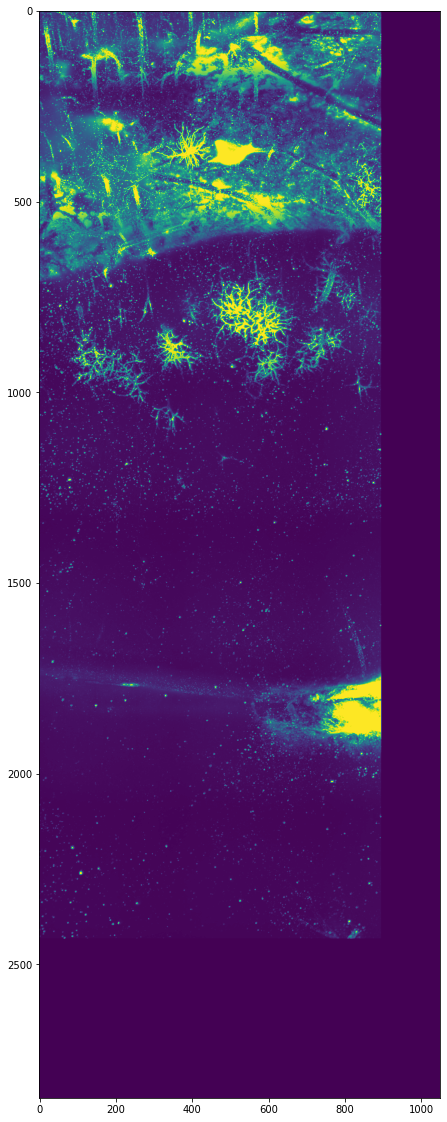

In [44]:
# ims2 = np.load("im175.npy")
plt.figure(figsize=(20,20))
plt.imshow(ims.max(0))

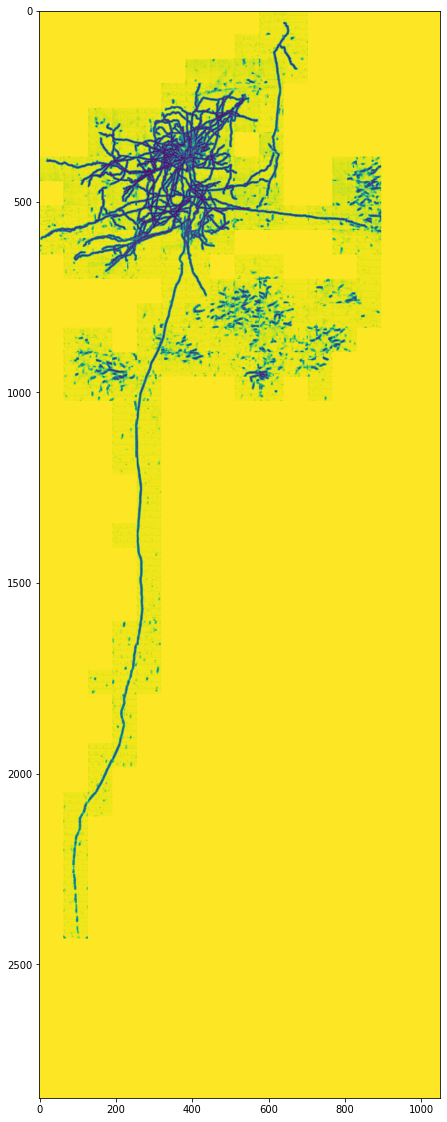

In [51]:
# preds2 = np.load("pred175.npy")
plt.figure(figsize=(20,20))
#plt.imshow(preds2.min(0)) ??
plt.imshow(preds.min(0))

In [30]:
np.save("./im175.npy", ims)
np.save("./pred175.npy", preds)

In [17]:
ims = np.load("./im175.npy")
preds = np.load("./pred175.npy")

# Brain 225

### Find starting cube

In [24]:
nodes = readSWC(225)
coords = getCoords(225)
xs,ys,zs = getCubeCoords(225)
cubes = findCubes(225)

In [25]:
current_cube = cubes[0]
im225 = np.float32(getCube(225, current_cube)/65535)

In [26]:
current_cube

[14, 33, 2]

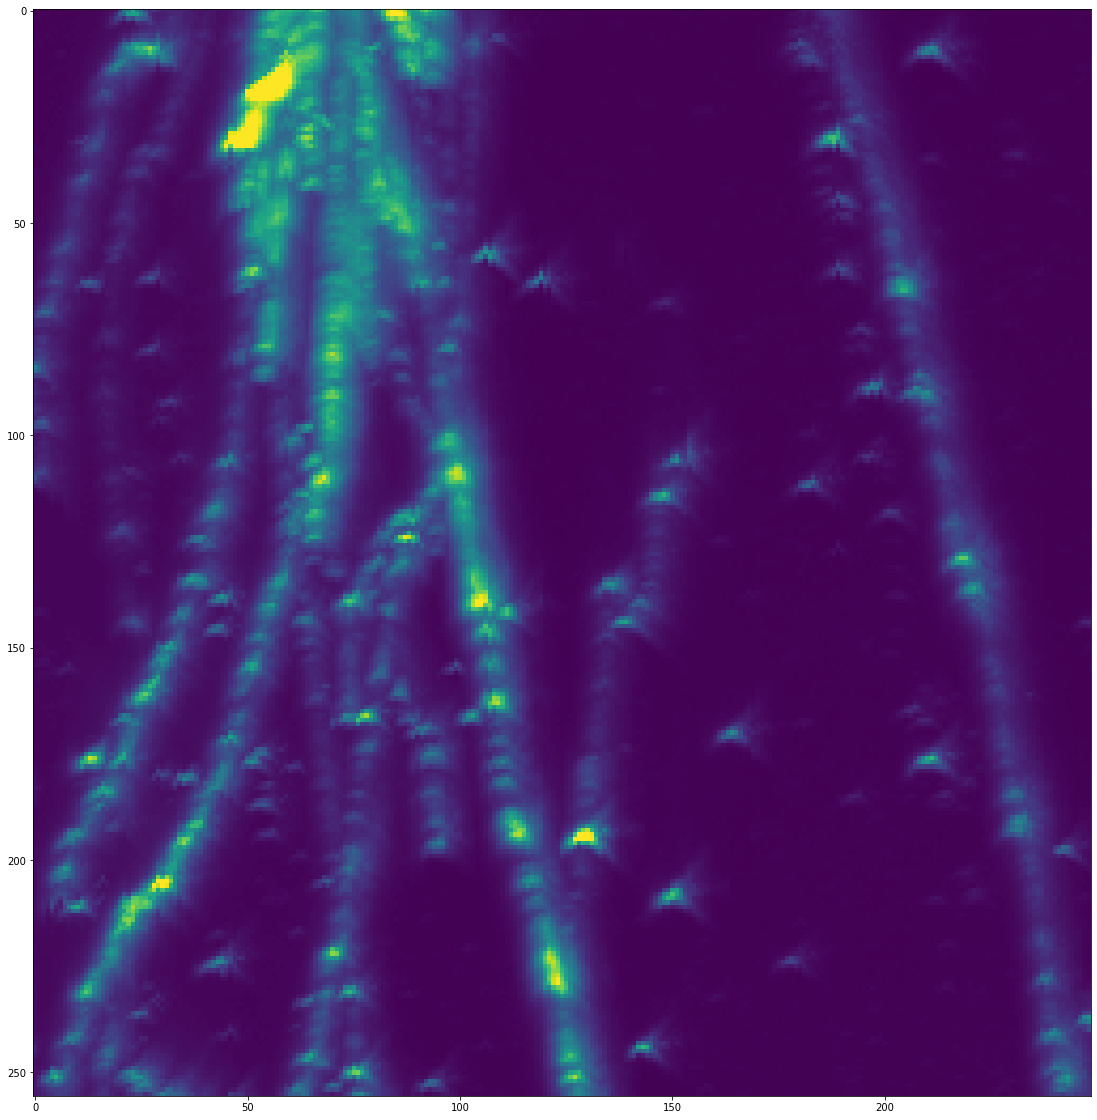

In [27]:
plt.figure(figsize=(20,20))
plt.imshow(im225.max(0))

In [28]:
pred225 = segmentCube(im225, network)

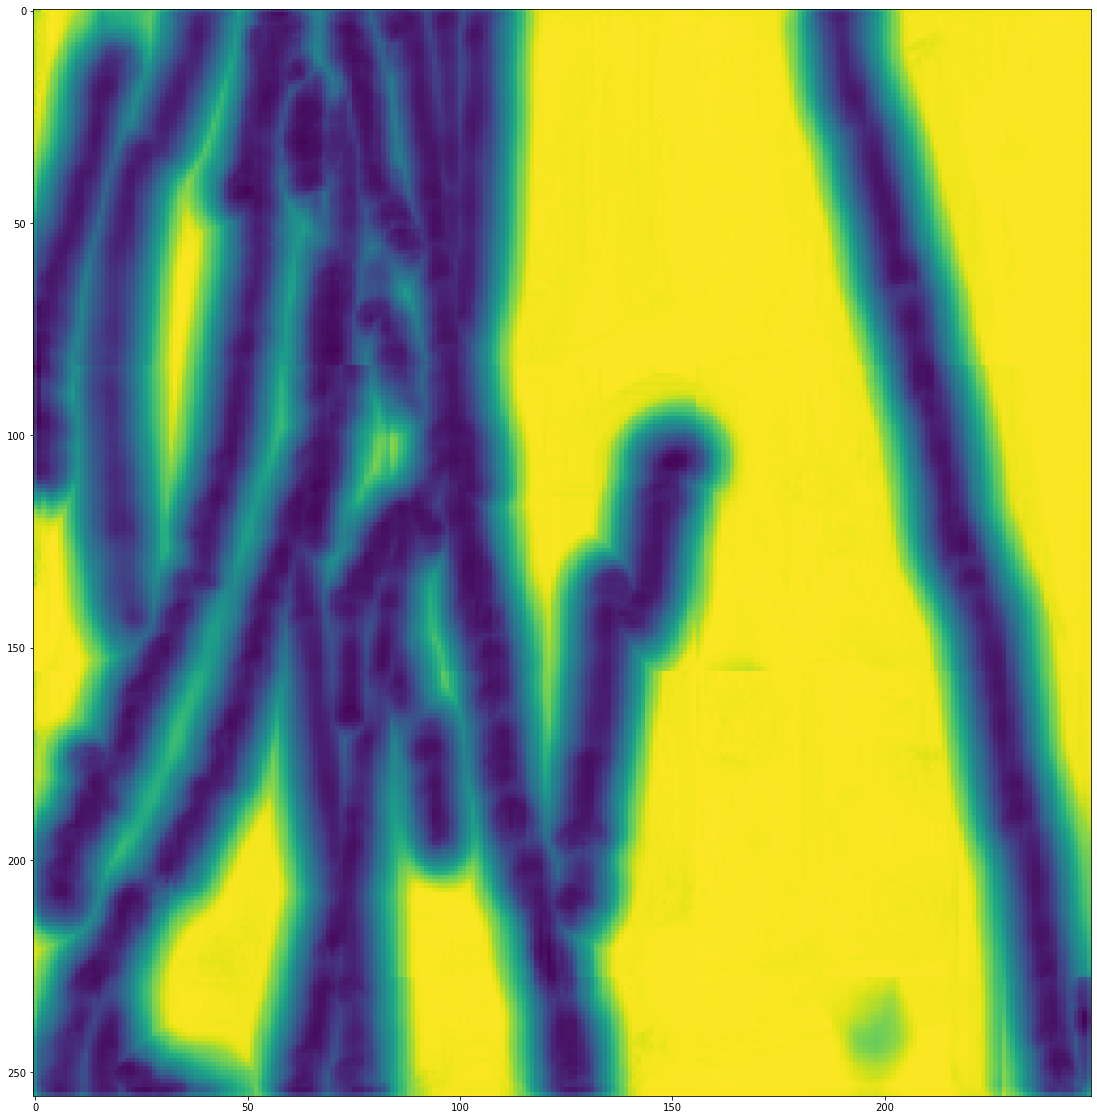

In [29]:
plt.figure(figsize=(20,20))
plt.imshow(pred225.min(0))

### Visualize pred

# Brain 250

### Find starting cube

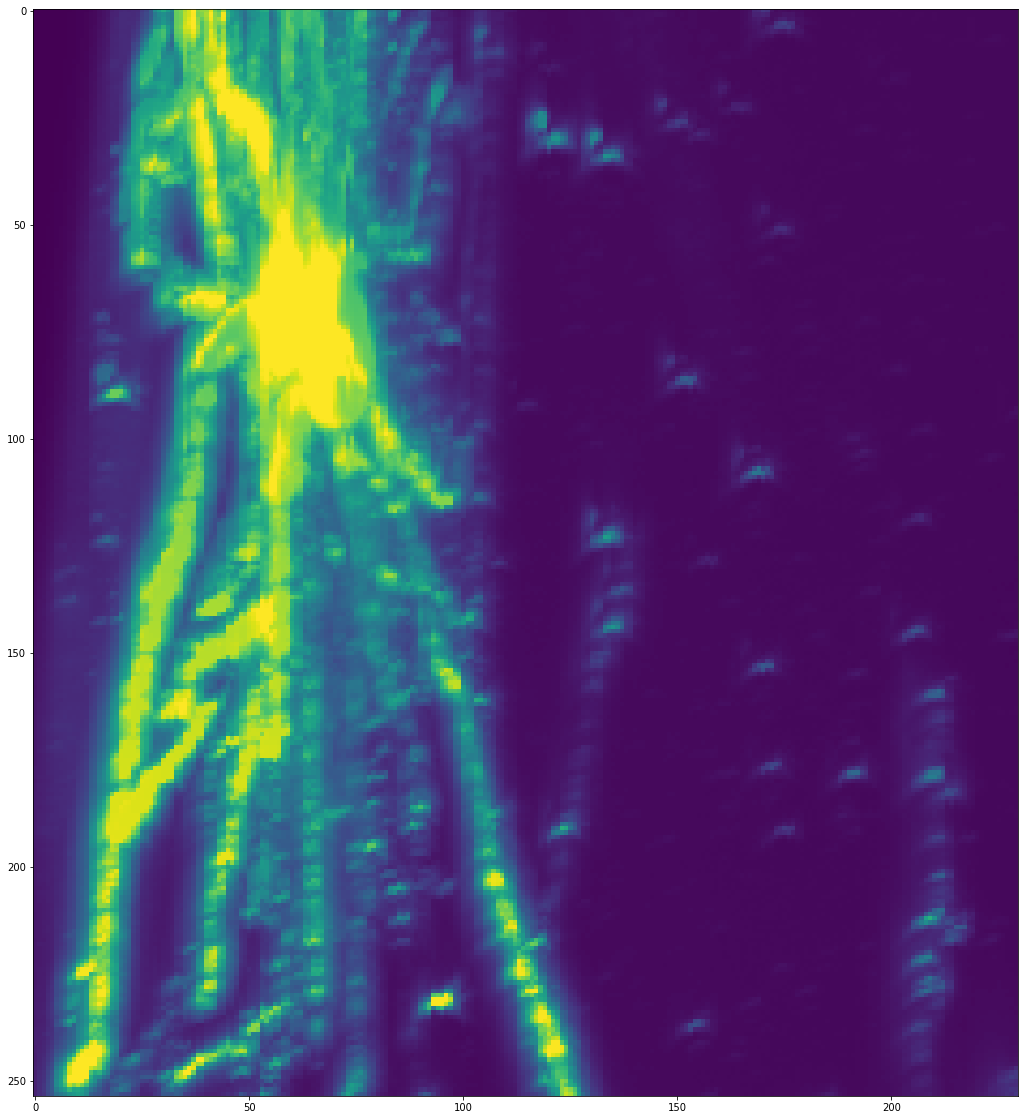

In [30]:
nodes = readSWC(250)
coords = getCoords(250)
xs,ys,zs = getCubeCoords(250)
cubes = findCubes(250)

current_cube = cubes[0]
im250 = np.float32(getCube(250, current_cube)/65535)

plt.figure(figsize=(20,20))
plt.imshow(im250.max(0))

In [31]:
current_cube

[13, 34, 1]

In [32]:
pred250 = segmentCube(im250, network)

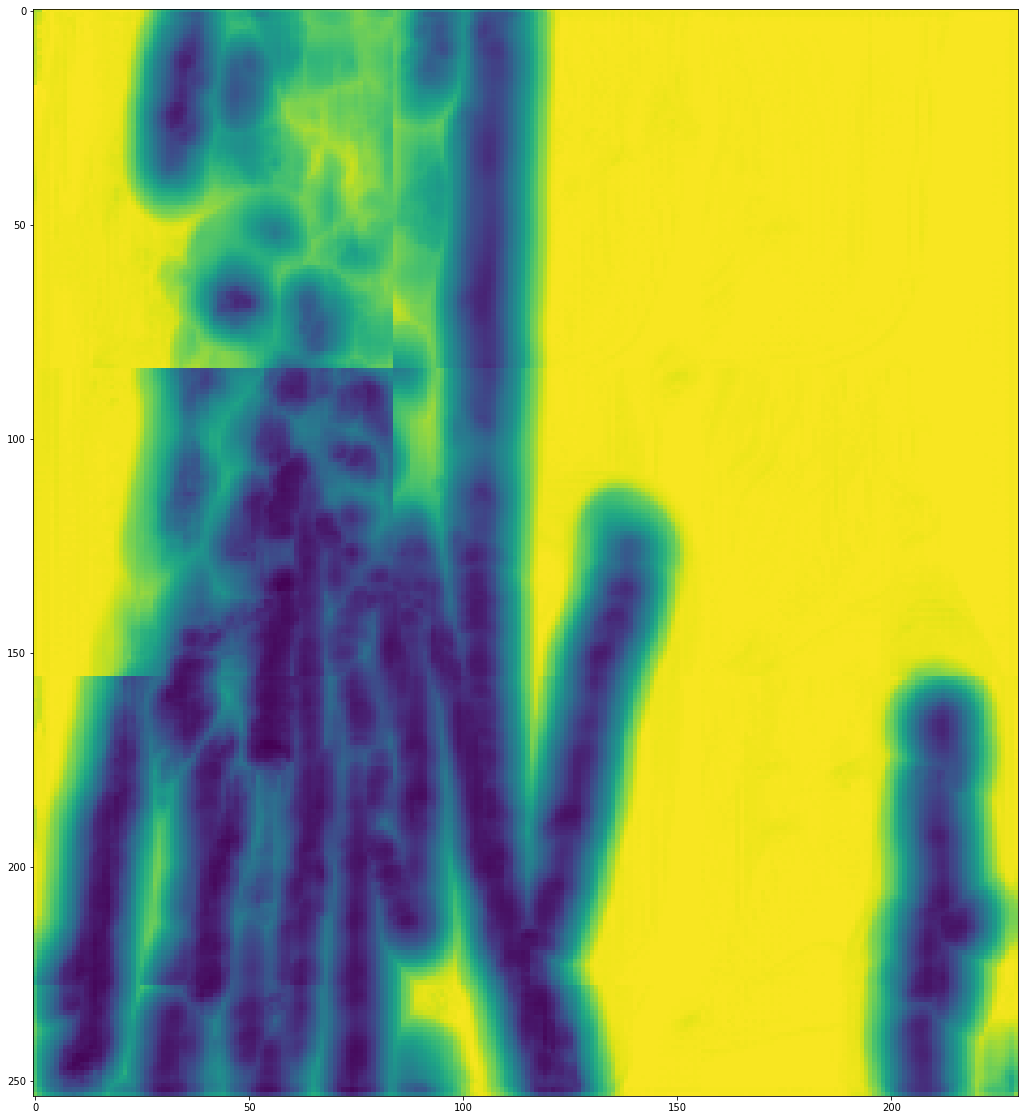

In [33]:
plt.figure(figsize=(20,20))
plt.imshow(pred250.min(0))

### Visualize pred

# Brain 177

### Find starting cube

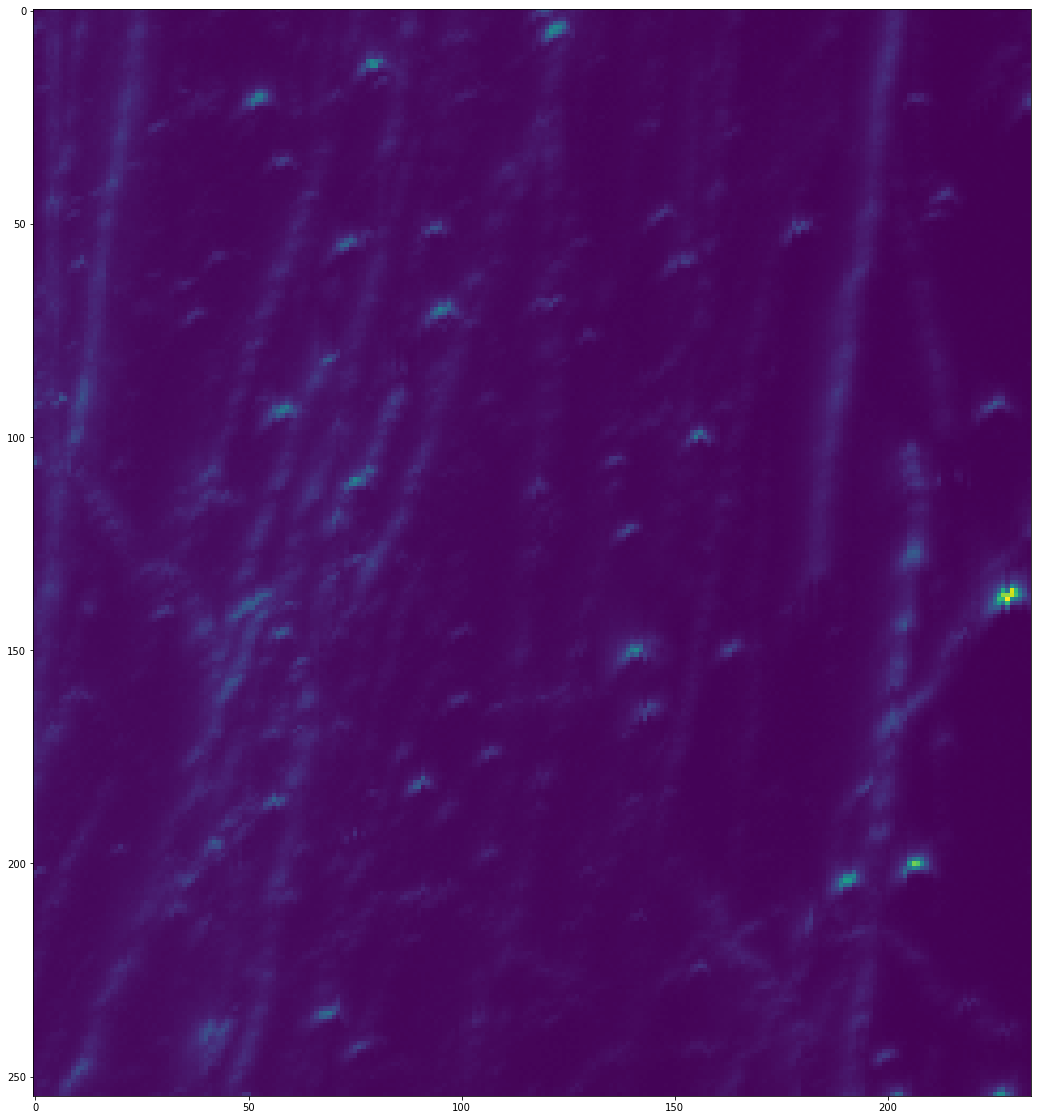

In [39]:
nodes = readSWC(177)
coords = getCoords(177)
xs,ys,zs = getCubeCoords(177)
cubes = findCubes(177)

current_cube = cubes[0]
im177 = np.float32(getCube(177, current_cube)/65535)

plt.figure(figsize=(20,20))
plt.imshow(im177.max(0))

In [40]:
current_cube

[8, 32, 4]

In [41]:
pred177 = segmentCube(im177, network)

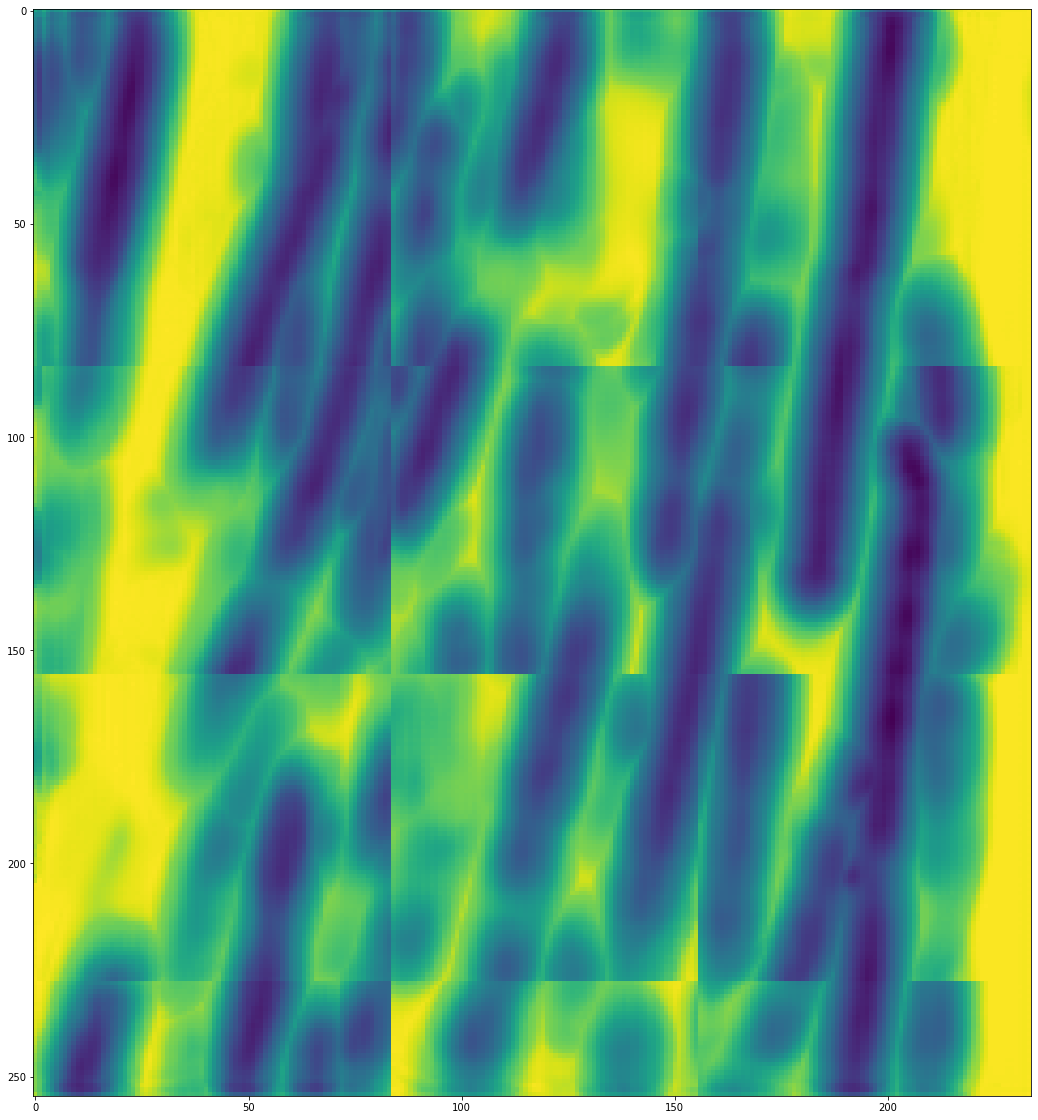

In [42]:
plt.figure(figsize=(20,20))
plt.imshow(pred177.min(0))

### Visualize pred